# Bayesian signal de-blending with Gaussian Random Fields

Florent Leclercq,<br/>
Institute of Cosmology and Gravitation, University of Portsmouth,<br/>
florent.leclercq@polytechnique.org

In [1]:
import numpy as np
import scipy.linalg
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
N=1000
epsilon=0.000000000001

## Setup signal covariance

In [3]:
# A Lorentzian distribution
gamma=2.5
signalcovar=np.array([1./(np.pi*gamma*(1+x*x/(gamma*gamma))) for x in xrange(N)])

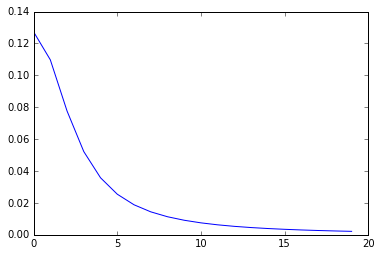

In [4]:
plt.plot(np.arange(20),signalcovar[:20])
plt.show()

In [5]:
Cx1x1_Fourier=np.diagflat(signalcovar)
Cx1x1=Cx2x2=np.fft.ifft(np.fft.fft(Cx1x1_Fourier).T).T.real
sqrtCx1x1_Fourier=np.diagflat(np.sqrt(signalcovar))
sqrtCx1x1=sqrtCx2x2=np.fft.ifft(np.fft.fft(sqrtCx1x1_Fourier).T).T.real

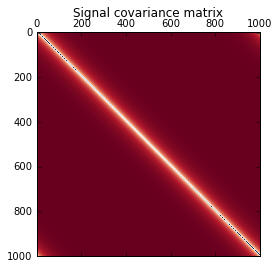

In [6]:
plt.matshow(sqrtCx1x1, cmap='RdBu')
plt.title("Signal covariance matrix")
plt.show()

## Setup noise covariance

In [7]:
%%latex
\begin{equation}
n = \begin{bmatrix} n_1 \\ n_2 \\ n_3 \end{bmatrix}
\end{equation}
\begin{equation}
C_{nn} = \begin{bmatrix} C_{n_1n_1} & 0 & 0 \\ 0 & C_{n_2n_2} & 0 \\ 0 & 0 & C_{n_3n_3} \end{bmatrix}
\end{equation}

<IPython.core.display.Latex object>

### 1-Easy case: non-blended regions are not masked 

In [8]:
noisepower=0.00005*np.ones(N)
Cn1n1=Cn2n2=Cn3n3=np.diagflat(noisepower)
sqrtCn1n1=sqrtCn2n2=sqrtCn3n3=np.diagflat(np.sqrt(noisepower))
Cnn=np.bmat([[Cn1n1,          np.zeros((N,N)), np.zeros((N,N))],\
            [np.zeros((N,N)), Cn2n2,           np.zeros((N,N))],\
            [np.zeros((N,N)), np.zeros((N,N)), Cn3n3]])

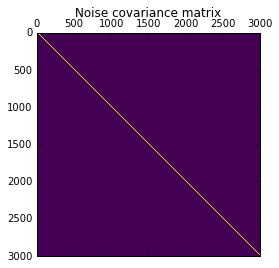

In [9]:
plt.matshow(Cnn, cmap='viridis')
plt.title("Noise covariance matrix")
plt.show()

### 2-Difficult case: non-blended regions are masked

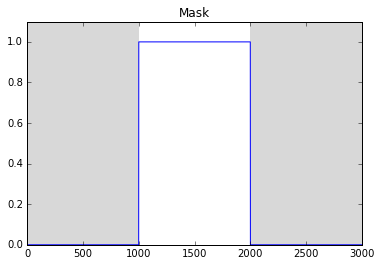

In [10]:
mask=np.ones(3*N)
mask[0:N]=0.
mask[N:2*N]=1.
mask[2*N:3*N]=0.
plt.ylim(0,1.1)
plt.plot(np.arange(3*N),mask)
plt.fill_between([0,N],0.,1.1,facecolor='grey',alpha=0.3, linewidth=0.)
plt.fill_between([2*N,3*N],0.,1.1,facecolor='grey',alpha=0.3, linewidth=0.)
plt.title("Mask")
plt.show()

In [11]:
noisepower=0.00005*np.ones(N)
Cn2n2=np.diagflat(noisepower)
sqrtCn2n2=np.diagflat(np.sqrt(noisepower))
Cn1n1=Cn3n3=np.diagflat(np.ones(N))
sqrtCn1n1=sqrtCn3n3=np.diagflat(np.ones(N))
Cnn=np.bmat([[Cn1n1,          np.zeros((N,N)), np.zeros((N,N))],\
            [np.zeros((N,N)), Cn2n2,           np.zeros((N,N))],\
            [np.zeros((N,N)), np.zeros((N,N)), Cn3n3]])

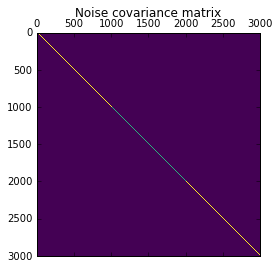

In [12]:
plt.matshow(np.log(Cnn+epsilon), cmap='viridis')
plt.title("Noise covariance matrix")
plt.show()

## Generate mock data

In [13]:
#The truth
x1=sqrtCx1x1.real.dot(np.random.normal(0.,1.,N))
x2=sqrtCx2x2.real.dot(np.random.normal(0.,1.,N))

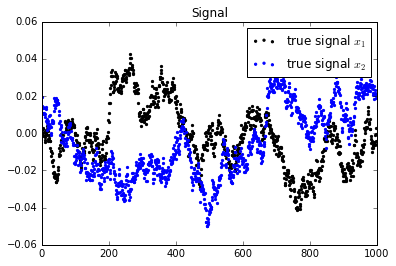

In [14]:
plt.xlim(0,N)
plt.scatter(np.arange(N),x1,marker='.',color='black',label="true signal $x_1$")
plt.scatter(np.arange(N),x2,marker='.',color='blue',label="true signal $x_2$")
plt.title("Signal")
plt.legend(loc='best')
plt.show()

In [15]:
#The noise, with infinite variance in masked regions
n1=sqrtCn1n1.real.dot(np.random.normal(0.,1.,N))
n2=sqrtCn2n2.real.dot(np.random.normal(0.,1.,N))
n3=sqrtCn3n3.real.dot(np.random.normal(0.,1.,N))

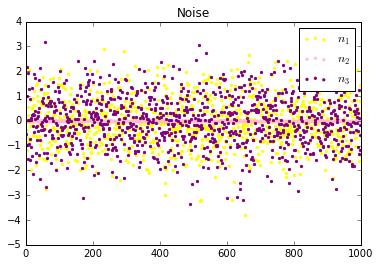

In [16]:
plt.xlim(0,N)
plt.scatter(np.arange(N),n1,marker='.',color='yellow',label='$n_1$')
plt.scatter(np.arange(N),n2,marker='.',color='pink',label='$n_2$')
plt.scatter(np.arange(N),n3,marker='.',color='purple',label='$n_3$')
plt.title("Noise")
plt.legend(loc='best')
plt.show()

In [17]:
%%latex
The data model:
\begin{equation}
d = \begin{bmatrix} d_1 \\ d_2 \\ d_3 \end{bmatrix} =\
    \begin{bmatrix} x_1+n_1 \\ x_1+x_2+n_2  \\ x_2+n_3 \end{bmatrix}
\end{equation}

<IPython.core.display.Latex object>

In [18]:
d1=x1+n1
d2=x1+x2+n2
d3=x2+n3

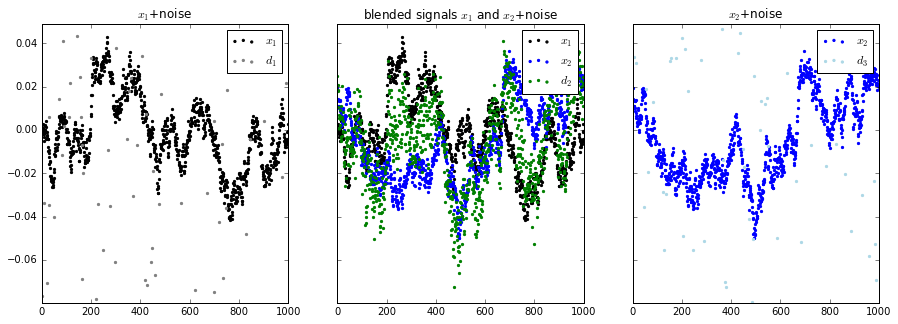

In [19]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))
ax1.set_xlim(0,N)
ax1.scatter(np.arange(N),x1,marker='.',color='black',label='$x_1$')
ax1.scatter(np.arange(N),d1,marker='.',color='grey',label='$d_1$')
ax1.set_title("$x_1$+noise")
ax1.legend(loc='best')
ax2.set_xlim(0,N)
ax2.set_ylim(d2.min()*1.1,d2.max()*1.1)
ax2.scatter(np.arange(N),x1,marker='.',color='black',label='$x_1$')
ax2.scatter(np.arange(N),x2,marker='.',color='blue',label='$x_2$')
ax2.scatter(np.arange(N),d2,marker='.',color='green',label='$d_2$')
ax2.set_title("blended signals $x_1$ and $x_2$+noise")
ax2.legend(loc='best')
ax3.set_xlim(0,N)
ax3.scatter(np.arange(N),x2,marker='.',color='blue',label='$x_2$')
ax3.scatter(np.arange(N),d3,marker='.',color='lightblue',label='$d_3$')
ax3.set_title("$x_2$+noise")
ax3.legend(loc='best')
plt.show()

## Setup Wiener de-blender

In [20]:
%%latex
Assumptions:
\begin{equation}
C_{x_1x_2} = C_{x_1n_1} = C_{x_1n_2} = C_{x_2n_2} = C_{x_2n_3} = 0
\end{equation}

<IPython.core.display.Latex object>

In [21]:
%%latex
\begin{eqnarray}
C_{x_1d} & = & \begin{bmatrix} C_{x_1x_1} & C_{x_1x_1} & 0 \end{bmatrix}; \quad C_{dx_1} = C_{x_1d}^\mathrm{T}\\
C_{x_2d} & = & \begin{bmatrix} 0 & C_{x_2x_2} & C_{x_2x_2} \end{bmatrix}; \quad C_{dx_2} = C_{x_2d}^\mathrm{T} \\
C_{dd} & = & \begin{bmatrix} C_{x_1x_1}+C_{n_1n_1} & C_{x_1x_1} & 0\\
C_{x_1x_1} & C_{x_1x_1}+C_{x_2x_2}+C_{n_2n_2} & C_{x_2x_2}\\
0 & C_{x_2x_2} & C_{x_2x_2}+C_{n_3n_3}
\end{bmatrix}
\end{eqnarray}

<IPython.core.display.Latex object>

In [22]:
d=np.bmat([[d1,d2,d3]]).T
Cx1d=np.bmat([[Cx1x1, Cx1x1, np.zeros((N,N))]])
Cdx1=Cx1d.T
Cx2d=np.bmat([[np.zeros((N,N)), Cx2x2, Cx2x2]])
Cdx2=Cx2d.T
Cdd=np.bmat([[Cx1x1+Cn1n1,     Cx1x1,             np.zeros((N,N))],\
             [Cx1x1,           Cx1x1+Cx2x2+Cn2n2, Cx2x2],\
             [np.zeros((N,N)), Cx2x2,             Cx2x2+Cn3n3]])
invCdd=np.linalg.inv(Cdd)

## Perform signal reconstruction

In [23]:
%%latex
\begin{eqnarray}
\mu_{x_1|d} & = & C_{x_1d}C_{dd}^{-1}d\\
\mu_{x_2|d} & = & C_{x_2d}C_{dd}^{-1}d
\end{eqnarray}

<IPython.core.display.Latex object>

In [24]:
x1WF=Cx1d.dot(invCdd).dot(d)
x2WF=Cx2d.dot(invCdd).dot(d)
x1WF=np.squeeze(np.asarray(x1WF))
x2WF=np.squeeze(np.asarray(x2WF))

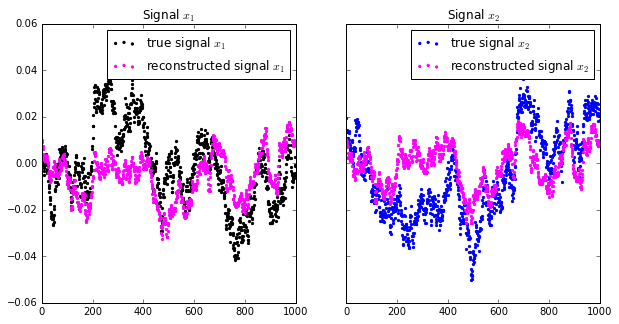

In [25]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax1.set_xlim(0,N)
ax1.scatter(np.arange(N),x1,marker='.',color='black',label="true signal $x_1$")
ax1.scatter(np.arange(N),x1WF,marker='.',color='magenta',label="reconstructed signal $x_1$")
ax1.set_title("Signal $x_1$")
ax1.legend(loc='best')
ax2.set_xlim(0,N)
ax2.scatter(np.arange(N),x2,marker='.',color='blue',label="true signal $x_2$")
ax2.scatter(np.arange(N),x2WF,marker='.',color='magenta',label="reconstructed signal $x_2$")
ax2.set_title("Signal $x_2$")
ax2.legend(loc='best')
plt.show()

## Generate constrained realizations

In [26]:
%%latex
\begin{eqnarray}
C_{x_1|d} & = & C_{x_1x_1} - C_{x_1d}C_{dd}^{-1}C_{dx_1}\\
C_{x_1|d} & = & C_{x_2x_2} - C_{x_2d}C_{dd}^{-1}C_{dx_2}\\
\end{eqnarray}

<IPython.core.display.Latex object>

In [27]:
Cx1WF=Cx1x1-Cx1d.dot(invCdd).dot(Cdx1)
Cx2WF=Cx2x2-Cx2d.dot(invCdd).dot(Cdx2)
sqrtCx1WF=scipy.linalg.sqrtm(Cx1WF)
sqrtCx2WF=scipy.linalg.sqrtm(Cx2WF)

In [28]:
x1cr1=sqrtCx1WF.dot(np.random.normal(0.,1.,N)).real+x1WF
x1cr2=sqrtCx1WF.dot(np.random.normal(0.,1.,N)).real+x1WF
x1cr3=sqrtCx1WF.dot(np.random.normal(0.,1.,N)).real+x1WF
x2cr1=sqrtCx2WF.dot(np.random.normal(0.,1.,N)).real+x2WF
x2cr2=sqrtCx2WF.dot(np.random.normal(0.,1.,N)).real+x2WF
x2cr3=sqrtCx2WF.dot(np.random.normal(0.,1.,N)).real+x2WF

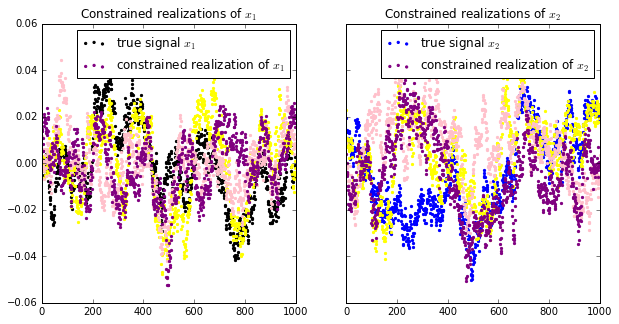

In [29]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))
ax1.set_xlim(0,N)
ax1.scatter(np.arange(N),x1,marker='.',color='black',label="true signal $x_1$")
ax1.scatter(np.arange(N),x1cr1,marker='.',color='yellow')
ax1.scatter(np.arange(N),x1cr2,marker='.',color='pink')
ax1.scatter(np.arange(N),x1cr3,marker='.',color='purple',label="constrained realization of $x_1$")
ax1.set_title("Constrained realizations of $x_1$")
ax1.legend(loc='best')
ax2.set_xlim(0,N)
ax2.scatter(np.arange(N),x2,marker='.',color='blue',label="true signal $x_2$")
ax2.scatter(np.arange(N),x2cr1,marker='.',color='yellow')
ax2.scatter(np.arange(N),x2cr2,marker='.',color='pink')
ax2.scatter(np.arange(N),x2cr3,marker='.',color='purple',label="constrained realization of $x_2$")
ax2.set_title("Constrained realizations of $x_2$")
ax2.legend(loc='best')
plt.show()